In [284]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import torch

## Data Cleaning & Preprocessing

In [285]:
# Load the data into a DataFrame
dateformat_str = "%Y-%m-%d %H:%M"
data = pd.read_csv('data/tsla_2019_2022.csv', na_values=[' '], skipinitialspace=True, date_format=dateformat_str, parse_dates=True) # some missing values in the dataset are given as an empty space

# Remove leading and trailing whitespace and square brackets from column names
data.columns = data.columns.str.strip('data.columns.str.strip(" []")')

# Display the column names
print("Column names:", data.columns)

print("Shape of data:", data.shape)

Column names: Index(['QUOTE_UNIXTIME', 'QUOTE_READTIME', 'QUOTE_DATE', 'QUOTE_TIME_HOURS',
       'UNDERLYING_LAST', 'EXPIRE_DATE', 'EXPIRE_UNIX', 'DTE', 'C_DELTA',
       'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST',
       'C_SIZE', 'C_BID', 'C_ASK', 'STRIKE', 'P_BID', 'P_ASK', 'P_SIZE',
       'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV',
       'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT'],
      dtype='object')
Shape of data: (2659259, 33)


In [286]:
# Convert cols with date/time to datetime data type
data["QUOTE_READTIME"] = pd.to_datetime(data["QUOTE_READTIME"], format="%Y-%m-%d %H:%M", exact=True)
data["QUOTE_DATE"] = pd.to_datetime(data["QUOTE_DATE"], format="%Y-%m-%d", exact=True)
data["EXPIRE_DATE"] = pd.to_datetime(data["EXPIRE_DATE"], format="%Y-%m-%d", exact=True)
# can use .dt.tz_localize(tz="US/Eastern") to set to Eastern time then convert to local timezone if we want to
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2659259 entries, 0 to 2659258
Data columns (total 33 columns):
 #   Column               Dtype         
---  ------               -----         
 0   QUOTE_UNIXTIME       int64         
 1   QUOTE_READTIME       datetime64[ns]
 2   QUOTE_DATE           datetime64[ns]
 3   QUOTE_TIME_HOURS     float64       
 4   UNDERLYING_LAST      float64       
 5   EXPIRE_DATE          datetime64[ns]
 6   EXPIRE_UNIX          int64         
 7   DTE                  float64       
 8   C_DELTA              float64       
 9   C_GAMMA              float64       
 10  C_VEGA               float64       
 11  C_THETA              float64       
 12  C_RHO                float64       
 13  C_IV                 float64       
 14  C_VOLUME             float64       
 15  C_LAST               float64       
 16  C_SIZE               object        
 17  C_BID                float64       
 18  C_ASK                float64       
 19  STRIKE               

In [287]:
print(data[data.isnull().any(axis=1)].shape)
# 897680/2659259 = 0.337 of rows have some missing value in some cols, so we shouldn't drop them since its a large portion of the dataset

(897680, 33)


In [288]:
# Display the first few rows of the DataFrame to ensure it loaded correctly
data.head()

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_LAST,P_DELTA,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT
0,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98465,0.00055,...,0.01,-0.00071,0.00003,0.00046,-0.00975,0.00000,2.22548,147.0,104.0,0.444
1,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98371,0.00067,...,0.02,-0.00109,0.00009,0.00058,-0.01010,-0.00001,2.08349,12.0,99.0,0.423
2,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98458,0.00069,...,0.02,-0.00122,0.00012,0.00113,-0.01435,0.00000,2.02359,15.0,94.0,0.402
3,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.99187,0.00049,...,0.01,-0.00134,0.00009,0.00139,-0.01465,0.00000,1.89504,0.0,89.0,0.380
4,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.99341,0.00039,...,0.01,-0.00176,0.00008,0.00105,-0.01467,0.00000,1.76812,91.0,84.0,0.359


### Realized Volatility

We need to calculate realized/historical volatility as that is the real volatility we want to predict. Implied volatility is calculated through solving for volatility using options price and other inputs at a given time using Black-Scholes and other models.

In [289]:
# extract underlying price for each day
underlying = data[['QUOTE_DATE', 'UNDERLYING_LAST']]
underlying = underlying.drop_duplicates(subset=['QUOTE_DATE'])

# Verify there is only one price per date
if underlying['QUOTE_DATE'].duplicated().any():
    print("Warning: There are multiple prices for at least one date.")
else:
    print("Each date has a unique price.")

# Check if the DataFrame is sorted by 'QUOTE_DATE'
if underlying['QUOTE_DATE'].is_monotonic_increasing:
    print("The DataFrame is sorted by date.")
else:
    # underlying['Prev_QUOTE_DATE'] = underlying['QUOTE_DATE'].shift(1)
    # unsorted_rows = underlying[underlying['QUOTE_DATE'] < underlying['Prev_QUOTE_DATE']]
    # print("Adjacent rows that are not sorted:")
    # print(unsorted_rows[['Prev_QUOTE_DATE', 'QUOTE_DATE']])
    print("The DataFrame is not sorted by date. Sorting now.")
    underlying = underlying.sort_values(by='QUOTE_DATE')



# calculate log returns and realized volatility of the underlying
window_size = 10  # trading days in rolling window
dpy = 252  # trading days per year
ann_factor = dpy / window_size
# https://stackoverflow.com/questions/43284304/how-to-compute-volatility-standard-deviation-in-rolling-window-in-pandas
underlying['LOG_RETURNS'] = np.log(underlying['UNDERLYING_LAST']) - np.log(underlying['UNDERLYING_LAST'].shift(1))
underlying['REALIZED_VOL'] = np.sqrt(underlying['LOG_RETURNS'].rolling(window=window_size).var() * ann_factor)

Each date has a unique price.
The DataFrame is not sorted by date. Sorting now.


In [290]:
print(underlying['REALIZED_VOL'].unique())
underlying.dropna(inplace=True)

[       nan 0.15469482 0.13626489 ... 0.25059357 0.30896178 0.31070019]


In [291]:
underlying.shape

(1000, 4)

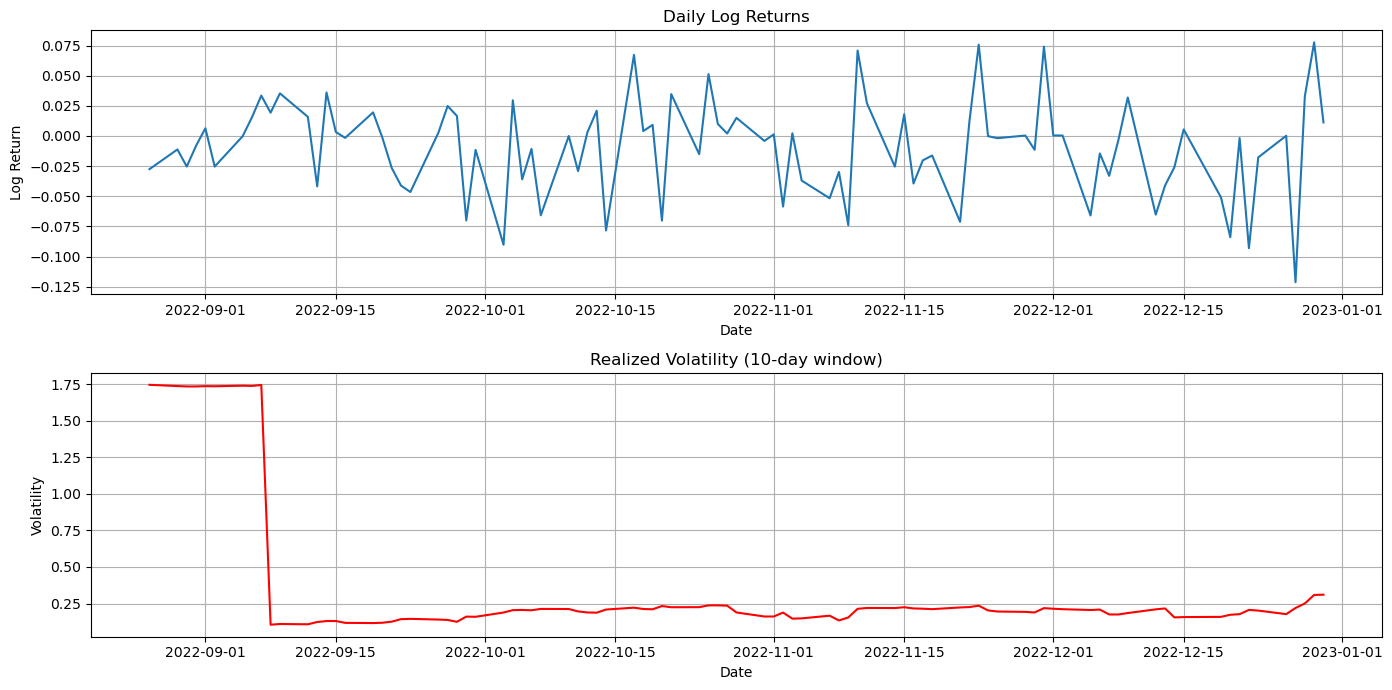

In [292]:
last_n_days = 90

plt.figure(figsize=(14, 7))

# Plotting Log Returns
plt.subplot(2, 1, 1)
plt.plot(underlying['QUOTE_DATE'][-last_n_days:], underlying['LOG_RETURNS'][-last_n_days:], label='Log Returns')
plt.title('Daily Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)

# Plotting Realized Volatility
plt.subplot(2, 1, 2)
plt.plot(underlying['QUOTE_DATE'][-last_n_days:], underlying['REALIZED_VOL'][-last_n_days:], label='Realized Volatility', color='red')
plt.title('Realized Volatility (10-day window)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)

plt.tight_layout()
plt.show()

In [293]:
# Join the 'log_returns' and 'realized_vol' columns back with the full options dataframe
data = pd.merge(data, underlying[['QUOTE_DATE', 'LOG_RETURNS', 'REALIZED_VOL']], on='QUOTE_DATE', how='left')
data.head()

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_GAMMA,P_VEGA,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,LOG_RETURNS,REALIZED_VOL
0,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98465,0.00055,...,0.00003,0.00046,-0.00975,0.00000,2.22548,147.0,104.0,0.444,-0.01993,0.124
1,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98371,0.00067,...,0.00009,0.00058,-0.01010,-0.00001,2.08349,12.0,99.0,0.423,-0.01993,0.124
2,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98458,0.00069,...,0.00012,0.00113,-0.01435,0.00000,2.02359,15.0,94.0,0.402,-0.01993,0.124
3,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.99187,0.00049,...,0.00009,0.00139,-0.01465,0.00000,1.89504,0.0,89.0,0.380,-0.01993,0.124
4,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.99341,0.00039,...,0.00008,0.00105,-0.01467,0.00000,1.76812,91.0,84.0,0.359,-0.01993,0.124


In [294]:
print(data[data['REALIZED_VOL'].isna() | data['LOG_RETURNS'].isna()].shape)
data = data.dropna(subset=['REALIZED_VOL', 'LOG_RETURNS'])
print(data[data['REALIZED_VOL'].isna() | data['LOG_RETURNS'].isna()].shape)
print(data.shape)

(15004, 35)
(0, 35)
(2644255, 35)


In [295]:
data['C_MID'] = (data['C_BID'] + data['C_ASK']) / 2
data['P_MID'] = (data['P_BID'] + data['P_ASK']) / 2
data.head()

,QUOTE_UNIXTIME,QUOTE_READTIME,QUOTE_DATE,QUOTE_TIME_HOURS,UNDERLYING_LAST,EXPIRE_DATE,EXPIRE_UNIX,DTE,C_DELTA,C_GAMMA,...,P_THETA,P_RHO,P_IV,P_VOLUME,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,LOG_RETURNS,REALIZED_VOL,C_MID,P_MID
0,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98465,0.00055,...,-0.00975,0.00000,2.22548,147.0,104.0,0.444,-0.01993,0.124,104.400,0.010
1,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98371,0.00067,...,-0.01010,-0.00001,2.08349,12.0,99.0,0.423,-0.01993,0.124,99.400,0.015
2,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.98458,0.00069,...,-0.01435,0.00000,2.02359,15.0,94.0,0.402,-0.01993,0.124,94.325,0.020
3,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.99187,0.00049,...,-0.01465,0.00000,1.89504,0.0,89.0,0.380,-0.01993,0.124,89.125,0.020
4,1556740800,2019-05-01 16:00:00,2019-05-01,16.0,233.98,2019-05-03,1556913600,2.0,0.99341,0.00039,...,-0.01467,0.00000,1.76812,91.0,84.0,0.359,-0.01993,0.124,84.070,0.015


In [296]:
data['REALIZED_VOL'].unique()

array([0.12400049, 0.1544875 , 0.17575756, 0.16673064, 0.17253261,
       0.17107855, 0.15780428, 0.13309884, 0.15081668, 0.15683428,
       0.15389325, 0.13482822, 0.14479528, 0.14077375, 0.14264954,
       0.15670627, 0.16750756, 0.16636182, 0.15784446, 0.14802027,
       0.14567849, 0.14567451, 0.30091549, 0.2955583 , 0.29712502,
       0.29392283, 0.16786895, 0.09158185, 0.09666024, 0.06570285,
       0.07085118, 0.06917919, 0.06322281, 0.06931884, 0.07138631,
       0.08094455, 0.07398918, 0.13303982, 0.12765854, 0.12743061,
       0.12853156, 0.12616877, 0.221064  , 0.22410604, 0.22138524,
       0.21895673, 0.22713392, 0.22202587, 0.18814791, 0.18512389,
       0.20522958, 0.16336753, 0.18837439, 0.20448189, 0.19906926,
       0.20575513, 0.18742406, 0.21218093, 0.20930362, 0.19768372,
       0.15926314, 0.13801378, 0.14349209, 0.15157751, 0.16349188,
       0.10879913, 0.1043701 , 0.10182496, 0.1095444 , 0.11851752,
       0.13294798, 0.13657743, 0.18741666, 0.15836698, 0.18639

In [297]:
underlying.shape # total unique dates

(1000, 4)

In [298]:
date_counts = data.groupby('QUOTE_DATE').size()

# Print the result to verify
print(date_counts) # check if all dates have the same row count => they don't

QUOTE_DATE
2019-01-16    1522
2019-01-17    1525
2019-01-18    1525
2019-01-22    1421
2019-01-23    1456
              ... 
2022-12-26    1852
2022-12-27    1852
2022-12-28    2071
2022-12-29    2096
2022-12-30    2098
Length: 1000, dtype: int64


Now, I want to parse for ATM strikes. To do this, I will only be looking at options where the delta is between 45-55, or -45 to -55.

In [299]:
# Filter data to include only ATM options (where delta is closest to 0.5)
# Ensure column names match exactly what's in the DataFrame
atm_options = data[(data['C_DELTA'] >= 0.45) & (data['C_DELTA'] <= 0.55) & (data['P_DELTA'] >= -0.55) & (data['P_DELTA'] <= -0.45)]

# Display the first few rows of the filtered DataFrame
print("Number of rows in atm_options:", len(atm_options))
print(atm_options.head())
print(atm_options.tail())

Number of rows in atm_options: 119232
     QUOTE_UNIXTIME      QUOTE_READTIME QUOTE_DATE  QUOTE_TIME_HOURS  \
27       1556740800 2019-05-01 16:00:00 2019-05-01              16.0   
98       1556740800 2019-05-01 16:00:00 2019-05-01              16.0   
99       1556740800 2019-05-01 16:00:00 2019-05-01              16.0   
181      1556740800 2019-05-01 16:00:00 2019-05-01              16.0   
275      1556740800 2019-05-01 16:00:00 2019-05-01              16.0   

     UNDERLYING_LAST EXPIRE_DATE  EXPIRE_UNIX   DTE  C_DELTA  C_GAMMA  ...  \
27            233.98  2019-05-03   1556913600   2.0  0.46754  0.04011  ...   
98            233.98  2019-05-10   1557518400   9.0  0.54695  0.01962  ...   
99            233.98  2019-05-10   1557518400   9.0  0.49653  0.02035  ...   
181           233.98  2019-05-17   1558123200  16.0  0.50681  0.01542  ...   
275           233.98  2019-05-24   1558728000  23.0  0.54600  0.01265  ...   

     P_THETA    P_RHO     P_IV  P_VOLUME  STRIKE_DISTANCE  \

In [300]:
# Check for other missing values or zero values (zero isn't necessarily bad, but missing values for sure are)
zero_count = (atm_options == 0).sum() / atm_options.shape[0]
missing_count = atm_options.isna().sum() / atm_options.shape[0]

print(f"Number of zero values per feature: {zero_count}")
print(f"Number of missing values per feature: {missing_count}")

Number of zero values per feature: QUOTE_UNIXTIME         0.000000
QUOTE_READTIME         0.000000
QUOTE_DATE             0.000000
QUOTE_TIME_HOURS       0.000000
UNDERLYING_LAST        0.000000
EXPIRE_DATE            0.000000
EXPIRE_UNIX            0.000000
DTE                    0.000193
C_DELTA                0.000000
C_GAMMA                0.000000
C_VEGA                 0.000000
C_THETA                0.000000
C_RHO                  0.000000
C_IV                   0.000000
C_VOLUME               0.126812
C_LAST                 0.032131
C_SIZE                 0.000000
C_BID                  0.000034
C_ASK                  0.000000
STRIKE                 0.000000
P_BID                  0.000034
P_ASK                  0.000000
P_SIZE                 0.000000
P_LAST                 0.131978
P_DELTA                0.000000
P_GAMMA                0.000000
P_VEGA                 0.000000
P_THETA                0.000000
P_RHO                  0.000000
P_IV                   0.000000
P_VOL

Zero values shouldn't be a concern, but missing values are.

We can drop rows with missing values if we choose to select them as inputs, otherwise just ignore them because we will only select relevant columns anyways.

Note that for since we only want to predict realized volatility, we don't need to do anything with the validation and test data frame due to them already being complete (dropped missing values already, and those DFs only have two columns).

In [301]:
atm_options.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119232 entries, 27 to 2659230
Data columns (total 37 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   QUOTE_UNIXTIME       119232 non-null  int64         
 1   QUOTE_READTIME       119232 non-null  datetime64[ns]
 2   QUOTE_DATE           119232 non-null  datetime64[ns]
 3   QUOTE_TIME_HOURS     119232 non-null  float64       
 4   UNDERLYING_LAST      119232 non-null  float64       
 5   EXPIRE_DATE          119232 non-null  datetime64[ns]
 6   EXPIRE_UNIX          119232 non-null  int64         
 7   DTE                  119232 non-null  float64       
 8   C_DELTA              119232 non-null  float64       
 9   C_GAMMA              119232 non-null  float64       
 10  C_VEGA               119232 non-null  float64       
 11  C_THETA              119232 non-null  float64       
 12  C_RHO                119232 non-null  float64       
 13  C_IV             

In [302]:
# FEATURE SELECTION
# XXX: can't have multiple rows in one date because LSTM doesn't know what a "date" is and uses timesteps to keep track of "dates" instead, so either we need to transform all the different strike prices and DTE for each date into columns, or need to aggregate them somehow; right now I will just aggregate or remove them altogether
# TODO: try different features or ways to increase data given to the model
selected_features = ['QUOTE_UNIXTIME', 'LOG_RETURNS', 'STRIKE', 'C_MID', 'REALIZED_VOL', 'C_IV', 'P_IV', 'P_MID'] # use QUOTE_UNIXTIME instead of QUOTE_DATE for ML to be able to parse
selected_data = atm_options[selected_features]
print(f"selected_data shape pre-aggregation: {selected_data.shape[0]}")

# Engineering features to summarize multiple entries per date
selected_data = selected_data.groupby('QUOTE_UNIXTIME', as_index=True).agg({
    'REALIZED_VOL': ['mean'], # should all be the same anyways for each date
    'STRIKE': ['mean', 'min', 'max'],  # Aggregate strike prices
    'C_MID': ['mean', 'min', 'max'],  # Last price of calls (midpoint between bid/ask)
    'P_MID': ['mean', 'min', 'max'],  # Last price of puts (midpoint between bid/ask)
    'LOG_RETURNS': ['mean'], # should all be the same anyways for each date??
    'C_IV': ['min', 'mean', 'max'],
    'P_IV': ['min', 'mean', 'max'],
    # Add more features as necessary
}).reset_index()


print(f"Number of rows in selected_data set pre-drop: {selected_data.shape[0]}")
selected_data.dropna(inplace=True)
print(f"selected_data shape post-drop: {selected_data.shape}")
selected_data.info()

# data['C_VOLUME'].fillna(0, inplace=True) # option to fill with 0s

selected_data shape pre-aggregation: 119232
Number of rows in selected_data set pre-drop: 1000
selected_data shape post-drop: (1000, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (QUOTE_UNIXTIME, )    1000 non-null   int64  
 1   (REALIZED_VOL, mean)  1000 non-null   float64
 2   (STRIKE, mean)        1000 non-null   float64
 3   (STRIKE, min)         1000 non-null   float64
 4   (STRIKE, max)         1000 non-null   float64
 5   (C_MID, mean)         1000 non-null   float64
 6   (C_MID, min)          1000 non-null   float64
 7   (C_MID, max)          1000 non-null   float64
 8   (P_MID, mean)         1000 non-null   float64
 9   (P_MID, min)          1000 non-null   float64
 10  (P_MID, max)          1000 non-null   float64
 11  (LOG_RETURNS, mean)   1000 non-null   float64
 12  (C_IV, min)           1000 non-null   

## Training-Validation-Test Set Split
Split the dataset into training, validation, and testing set using 85-14-1% split by dates in chronological order (row count for over all the dates is not uniform).

In [303]:
# Ensure the DataFrame is sorted by date
selected_data.sort_values('QUOTE_UNIXTIME', inplace=True)

# Find unique dates and the proportionate splits
unique_dates = selected_data['QUOTE_UNIXTIME'].unique()
total_dates = len(unique_dates)

# Calculate split indices
train_end_idx = int(total_dates * 0.8)
val_end_idx = train_end_idx + int(total_dates * 0.1)

# Dates for splitting
train_dates = unique_dates[:train_end_idx]
val_dates = unique_dates[train_end_idx:val_end_idx]
test_dates = unique_dates[val_end_idx:]

# Create the splits
train_df = selected_data[selected_data['QUOTE_UNIXTIME'].isin(train_dates)]
val_df = selected_data[selected_data['QUOTE_UNIXTIME'].isin(val_dates)]
test_df = selected_data[selected_data['QUOTE_UNIXTIME'].isin(test_dates)]

# Verify the splits
print(f"Training Set: {train_df.shape}")
print(f"Validation Set: {val_df.shape}")
print(f"Testing Set: {test_df.shape}")

Training Set: (800, 18)
Validation Set: (100, 18)
Testing Set: (100, 18)


### Data Normalization

In [304]:
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

In [305]:
train_df.head()

QUOTE_UNIXTIME REALIZED_VOL      STRIKE                    C_MID          \
                         mean        mean    min    max       mean     min   
0     1547672400     0.154695  361.830986  345.0  420.0  34.085845   4.600   
1     1547758800     0.136265  362.934783  345.0  420.0  34.138333   3.525   
2     1547845200     0.262809  321.071429  300.0  380.0  33.318357  10.400   
3     1548190800     0.242077  317.962963  297.5  380.0  33.771481   7.175   
4     1548277200     0.244556  308.664384  287.5  370.0  34.133562   5.825   

               P_MID                  LOG_RETURNS     C_IV                     \
      max       mean     min      max        mean      min      mean      max   
0  75.495  48.388732   4.820  132.505    0.005245  0.44407  0.546641  0.64142   
1  76.000  48.279130   3.675  129.820    0.003721  0.37924  0.538099  0.63402   
2  67.995  50.513500  10.450  129.555   -0.138963  0.51587  0.627371  0.74988   
3  65.005  51.881728   7.450  132.000   -0.011279  0.51371  0.660061  0.91057   
4  65.500  53.746712   5.835  130.775   -0.038613  0.52023  0.638721  0.89039   

      P_IV                     
       min      mean      max  
0  0.39523  0.513228  0.63307  
1  0.37588  0.506150  0.61938  
2  0.41959  0.589468  0.72937  
3  0.42589  0.633003  0.91848  
4  0.43176  0.601702  0.89694

In [306]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 0 to 799
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (QUOTE_UNIXTIME, )    800 non-null    int64  
 1   (REALIZED_VOL, mean)  800 non-null    float64
 2   (STRIKE, mean)        800 non-null    float64
 3   (STRIKE, min)         800 non-null    float64
 4   (STRIKE, max)         800 non-null    float64
 5   (C_MID, mean)         800 non-null    float64
 6   (C_MID, min)          800 non-null    float64
 7   (C_MID, max)          800 non-null    float64
 8   (P_MID, mean)         800 non-null    float64
 9   (P_MID, min)          800 non-null    float64
 10  (P_MID, max)          800 non-null    float64
 11  (LOG_RETURNS, mean)   800 non-null    float64
 12  (C_IV, min)           800 non-null    float64
 13  (C_IV, mean)          800 non-null    float64
 14  (C_IV, max)           800 non-null    float64
 15  (P_IV, min)           800 no

In [307]:
selected_data.head()

QUOTE_UNIXTIME REALIZED_VOL      STRIKE                    C_MID          \
                         mean        mean    min    max       mean     min   
0     1547672400     0.154695  361.830986  345.0  420.0  34.085845   4.600   
1     1547758800     0.136265  362.934783  345.0  420.0  34.138333   3.525   
2     1547845200     0.262809  321.071429  300.0  380.0  33.318357  10.400   
3     1548190800     0.242077  317.962963  297.5  380.0  33.771481   7.175   
4     1548277200     0.244556  308.664384  287.5  370.0  34.133562   5.825   

               P_MID                  LOG_RETURNS     C_IV                     \
      max       mean     min      max        mean      min      mean      max   
0  75.495  48.388732   4.820  132.505    0.005245  0.44407  0.546641  0.64142   
1  76.000  48.279130   3.675  129.820    0.003721  0.37924  0.538099  0.63402   
2  67.995  50.513500  10.450  129.555   -0.138963  0.51587  0.627371  0.74988   
3  65.005  51.881728   7.450  132.000   -0.011279  0.51371  0.660061  0.91057   
4  65.500  53.746712   5.835  130.775   -0.038613  0.52023  0.638721  0.89039   

      P_IV                     
       min      mean      max  
0  0.39523  0.513228  0.63307  
1  0.37588  0.506150  0.61938  
2  0.41959  0.589468  0.72937  
3  0.42589  0.633003  0.91848  
4  0.43176  0.601702  0.89694

In [308]:
# get index of output feature
output_feature_index = None
for idx, tf in enumerate(selected_data.columns.get_loc('REALIZED_VOL')):
    if tf == True:
        output_feature_index = idx
if output_feature_index is None:
    print("Cant find output feature index")
    
def create_sequences(df, window_size, output_feature_index):
    sequences = []
    output = []
    data_array = df.to_numpy()
    # data_array = df.drop(columns=['QUOTE_UNIXTIME']).to_numpy()  # Assuming 'QUOTE_UNIXTIME' is the date column

    for i in range(len(data_array) - window_size):
        sequences.append(data_array[i:(i + window_size)])
        output.append(data_array[i + window_size, output_feature_index])

    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(output, dtype=torch.float32)

# Scaling features (excluding date/time and realized_vol)
scaler = MinMaxScaler()
# TODO: XXX: ensure first two columns are date and output which we will exclude from transformatin 
train_df_scaled = train_df.copy()
train_df_scaled.iloc[:, 2:] = scaler.fit_transform(train_df.iloc[:, 2:])

val_df_scaled = val_df.copy()
val_df_scaled.iloc[:, 2:] = scaler.transform(val_df.iloc[:, 2:])

test_df_scaled = test_df.copy()
test_df_scaled.iloc[:, 2:] = scaler.transform(test_df.iloc[:, 2:])

train_df_scaled.drop(['QUOTE_UNIXTIME'], axis=1, inplace=True)
val_df_scaled.drop(['QUOTE_UNIXTIME'], axis=1, inplace=True)
test_df_scaled.drop(['QUOTE_UNIXTIME'], axis=1, inplace=True)


# Create sequences for PyTorch
X_train, y_train = create_sequences(train_df_scaled, window_size, output_feature_index)
X_val, y_val = create_sequences(val_df_scaled, window_size, output_feature_index)
X_test, y_test = create_sequences(test_df_scaled, window_size, output_feature_index)

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/var/folders/j4/5rkww2t94332tqwmg7r7y2k40000gn/T/ipykernel_50817/2772386813.py:33: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  train_df_scaled.drop(['QUOTE_UNIXTIME'], axis=1, inplace=True)
/var/folders/j4/5rkww2t94332tqwmg7r7y2k40000gn/T/ipykernel_50817/2772386813.py:34: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  val_df_scaled.drop(['QUOTE_UNIXTIME'], axis=1, inplace=True)
/var/folders/j4/5rkww2t94332tqwmg7r7y2k40000gn/T/ipykernel_50817/2772386813.py:35: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  test_df_scaled.drop(['QUOTE_UNIXTIME'], axis=1, inplace=True)


## Neural Network Implementation

Will need to train one model for calls and one for puts
Features:
- historical/realized volatility
- log returns
- ~~underlying price~~
- ~~option price (bid/ask)~~
- ~~DTE (days till expiration)~~ 
- ~~volume (?)~~
- ~~delta (?)~~
- implied volatility
- QUOTE_UNIXTIME

Loss function: MSE

In [309]:
import torch
import torch.nn as nn
import torch.optim as optim

class VolNet(nn.Module):
    def __init__(self, num_inputs):
        super(VolNet, self).__init__()
        self.num_inputs = num_inputs
        self.num_layers = 2
        self.hidden_size = 32
        self.num_outputs = 1
        
        self.lstm = nn.LSTM(input_size=num_inputs, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True) # up to 3 layers for LSTM
        self.dense = nn.Linear(in_features=self.hidden_size, out_features=self.num_outputs) # fully-connected layer
        
        # self.last_h = self.initHidden()
        # self.last_c = self.initHidden()
        
    def forward(self, x):
        # x should be of shape (batch, sequence, features)
        batch_size = x.shape[0]
        lstm_out, (hn, cn) = self.lstm(x, (self.initHidden(batch_size), self.initHidden(batch_size)))
        # self.last_h, self.last_c = hn, cn
        last_time_step_out = lstm_out[:, -1, :]  # Use the output from the last time step
        return self.dense(last_time_step_out)
    
    def initHidden(self, batch_size):
        if not batch_size:
            batch_size = self.hidden_size * self.num_layers
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        

In [310]:
X_train.shape

torch.Size([790, 10, 17])

In [311]:
model = VolNet(num_inputs=X_train.shape[-1]) # Adjust num_inputs based on your feature count

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50


val_yhat = []
val_y = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs).squeeze()
        labels.squeeze_()
        loss = criterion(outputs, labels)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs).squeeze()
            labels.squeeze_()
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            
            val_yhat.append(outputs.detach().cpu().numpy())
            val_y.append(labels.detach().cpu().numpy())
            
            
    avg_val_loss = total_val_loss / len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# # Can't test from this because the trainer reruns the data on many iterations, so data wont be sequential?
# val_yhat = np.hstack(val_yhat)
# val_y = np.hstack(val_y)

Epoch [1/50], Train Loss: 0.0256, Val Loss: 0.0021
Epoch [2/50], Train Loss: 0.0287, Val Loss: 0.0020
Epoch [3/50], Train Loss: 0.0138, Val Loss: 0.0008
Epoch [4/50], Train Loss: 0.0043, Val Loss: 0.0012
Epoch [5/50], Train Loss: 0.0051, Val Loss: 0.0008
Epoch [6/50], Train Loss: 0.0031, Val Loss: 0.0006
Epoch [7/50], Train Loss: 0.0027, Val Loss: 0.0006
Epoch [8/50], Train Loss: 0.0025, Val Loss: 0.0005
Epoch [9/50], Train Loss: 0.0024, Val Loss: 0.0006
Epoch [10/50], Train Loss: 0.0022, Val Loss: 0.0006
Epoch [11/50], Train Loss: 0.0020, Val Loss: 0.0006
Epoch [12/50], Train Loss: 0.0019, Val Loss: 0.0006
Epoch [13/50], Train Loss: 0.0018, Val Loss: 0.0006
Epoch [14/50], Train Loss: 0.0017, Val Loss: 0.0006
Epoch [15/50], Train Loss: 0.0016, Val Loss: 0.0006
Epoch [16/50], Train Loss: 0.0015, Val Loss: 0.0005
Epoch [17/50], Train Loss: 0.0015, Val Loss: 0.0008
Epoch [18/50], Train Loss: 0.0015, Val Loss: 0.0004
Epoch [19/50], Train Loss: 0.0018, Val Loss: 0.0013
Epoch [20/50], Train 

In [312]:
# val_y.shape

In [313]:
# # put the predicted and actual realized volatility side by side to compare
# val_compare = pd.DataFrame({'Predicted_RVol': val_yhat, 'Actual_RVol': val_y})
# print(val_compare.to_string())

In [314]:
# Testing Phase
# Assuming test_dataset is an instance of TensorDataset or similar

test_yhat = []
test_y = []

def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()
            labels.squeeze_()
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            test_yhat.append(outputs.detach().cpu().numpy())
            test_y.append(labels.detach().cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_loss:.4f}')
    return avg_loss


# Example of how you might call this function
test_loss = evaluate_model(model, test_loader, criterion)

test_yhat = np.hstack(test_yhat)
test_y = np.hstack(test_y)

Test Loss: 0.0004


In [315]:
# put the predicted and actual realized volatility side by side to compare
test_compare = pd.DataFrame({'Predicted_RVol': test_yhat, 'Actual_RVol': test_y})
print(test_compare.to_string())

    Predicted_RVol  Actual_RVol
0         0.145747     0.052210
1         0.097771     0.051984
2         0.085037     0.049260
3         0.081104     0.048048
4         0.079118     0.048873
5         0.077395     0.046966
6         0.077749     0.046264
7         0.075792     0.048459
8         0.075971     0.051645
9         0.077130     0.053016
10        0.086881     0.057398
11        0.084589     0.059167
12        0.078224     0.054938
13        0.069994     0.060042
14        0.064956     0.059832
15        0.062425     0.060622
16        0.062544     0.061435
17        0.062102     0.061844
18        0.061845     0.058942
19        0.060133     0.053404
20        0.057438     0.049562
21        0.055604     0.049010
22        0.053075     0.051371
23        0.051983     0.052995
24        0.051700     0.046556
25        0.049229     0.045334
26        0.049773     0.036166
27        0.047405     0.039666
28        0.045221     0.034918
29        0.042597     0.032708
30      

## Result Visualization

In [316]:
unique_dates_df = pd.to_datetime(unique_dates, unit='s', errors='coerce')

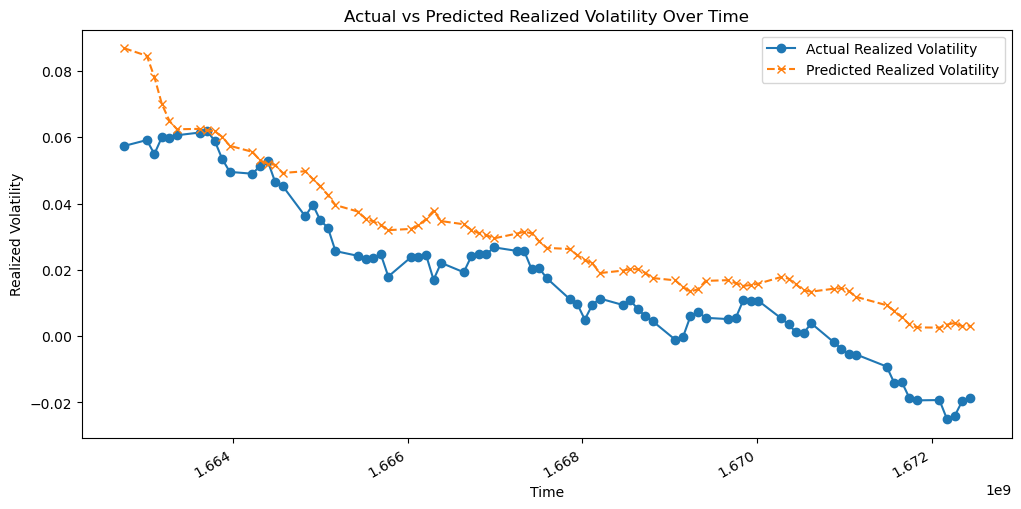

In [317]:
# Assuming dates_train_np holds the timestamps and you have a window_size (or sequence_length)

# adjusted_dates = dates_train_np[sequence_length - 1:]  # Skip the first sequence_length - 1 timestamps
ignore_first_n = 10
viz_dates = test_dates[window_size+ignore_first_n:]
viz_y = test_y[ignore_first_n:]
viz_yhat = test_yhat[ignore_first_n:]
# Plotting actual vs predicted realized volatility
plt.figure(figsize=(12, 6))
plt.plot(viz_dates, viz_y, label='Actual Realized Volatility', marker='o', linestyle='-')
plt.plot(viz_dates, viz_yhat, label='Predicted Realized Volatility', marker='x', linestyle='--')
plt.title('Actual vs Predicted Realized Volatility Over Time')
plt.xlabel('Time')
plt.ylabel('Realized Volatility')
plt.legend()
plt.gcf().autofmt_xdate()  # Improve formatting of date labels
plt.show()

## Full test over whole dataset



In [318]:
from torch.utils.data import ConcatDataset

# Assuming train_dataset, val_dataset, test_dataset are TensorDataset instances
# Concatenate the datasets
full_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])

# Create a DataLoader for the full dataset
full_loader = DataLoader(full_dataset, batch_size=16, shuffle=False)  # No need to shuffle for visualization

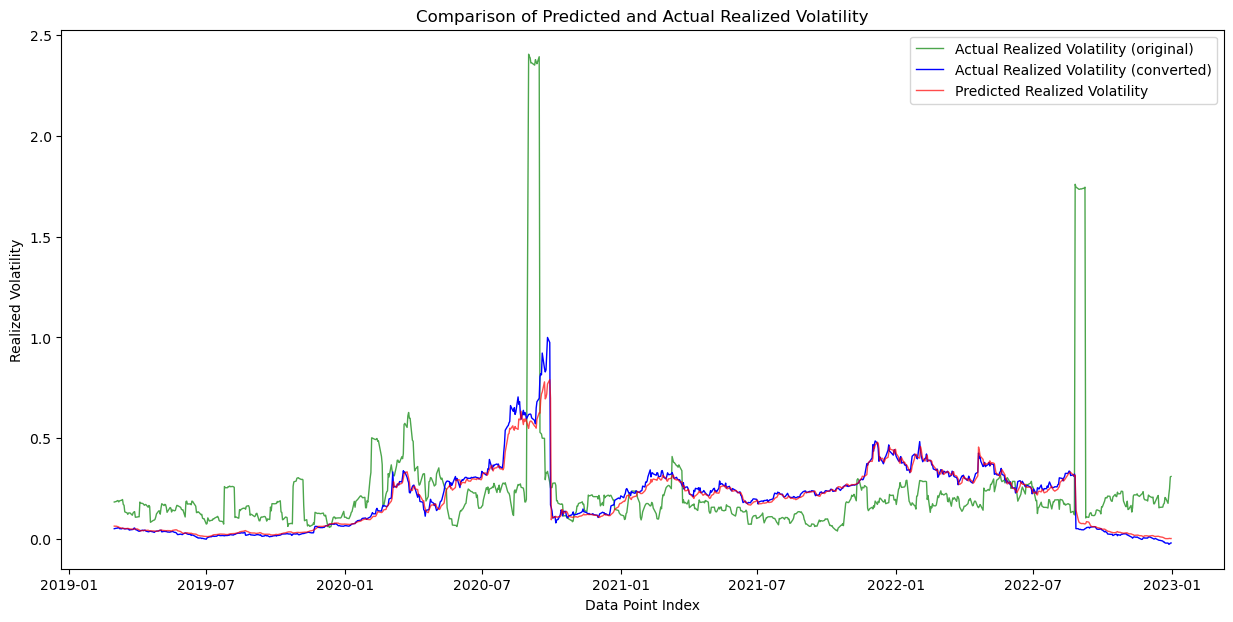

In [319]:
import matplotlib.pyplot as plt

def plot_predictions(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)
            # Assuming outputs and y_batch are already properly scaled
            predictions.extend(outputs.view(-1).cpu().numpy())  # Flatten and move to CPU
            actuals.extend(y_batch.view(-1).cpu().numpy())
    
    
    # Calculate the limits for the y-axis to exclude outliers
    # upper_limit = np.percentile(actuals, 99)  # Adjust the percentile as needed
    # lower_limit = np.percentile(actuals, 1)   # Adjust the percentile as needed

    # Plotting the results
    plt.figure(figsize=(15, 7))
    plt.plot(unique_dates_df[30:], underlying['REALIZED_VOL'][30:], label='Actual Realized Volatility (original)', color='green', alpha=0.7, linewidth=1)
    plt.plot(unique_dates_df[30:], actuals, label='Actual Realized Volatility (converted)', color='blue', linewidth=1)
    plt.plot(unique_dates_df[30:], predictions, label='Predicted Realized Volatility', color='red', alpha=0.7, linewidth=1)
    plt.title('Comparison of Predicted and Actual Realized Volatility')
    plt.xlabel('Data Point Index')
    plt.ylabel('Realized Volatility')
    # plt.ylim([lower_limit, upper_limit])  # Set the y-axis to not show the outlier
    plt.legend()
    plt.show()
# Assuming 'model' is already trained and ready to be evaluated
plot_predictions(model, full_loader)

# TODO: check source of discrepancy between the "actual realized volatility" from the ylabels and the realized vol from the underlying df; might be from missing values that got dropped.

> Need to tune the features
- ensure that the historical vol we have for each day is from the previous day and not the current day (since in practice we only have previous day's data).
- reduce window or something to make it more sensitive to changes.
- incorporate bid and ask prices at different strike prices (will need to deal with the date grouping issue, maybe use pivot_wider equivalent in pandas, although this will increase training time by a lot).